# SPT local background redshift trend
Author: Benjamin Floyd

Explores the possible redshift trend present in the local background measurements.

In [18]:
import json

import numpy as np
import ligo.skymap.plot
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.table import QTable, join, vstack
import astropy.units as u

In [3]:
# Read in the catalog and the results files
sptpol_iragn = QTable.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SPTcl_IRAGN.fits')

# Group to only have cluster information
sptcl_iragn_grp = sptpol_iragn.group_by('SPT_ID')
sptcl_clusters = vstack([QTable(cluster['SPT_ID', 'SZ_RA', 'SZ_DEC', 'REDSHIFT', 'M500', 'R500'][0])
                         for cluster in sptcl_iragn_grp.groups])

with (open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPTcl-local_bkg_frac_err.json', 'r') as f,
    open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPTcl-local_bkg_annulus.json', 'r') as g):
    local_bkgs = json.load(f)
    bkg_annuli = json.load(g)

# Convert the results into tables then merge it with the clusters table
local_bkgs = QTable(rows=[[cluster_name, bkg_value] for cluster_name, bkg_value in local_bkgs.items()],
                    names=['SPT_ID', 'local_bkg'], units=[None, u.deg ** -2])
bkg_annuli = QTable(rows=[[cluster_name, *list(annulus_data.values())] for cluster_name, annulus_data in bkg_annuli.items()],
                    names=['SPT_ID', 'inner_radius', 'outer_radius', 'annulus_area', 'frac_err'], 
                    units=[None, u.deg, u.deg, u.deg**2, None])
sptcl_clusters = join(sptcl_clusters, local_bkgs, keys='SPT_ID')
sptcl_clusters = join(sptcl_clusters, bkg_annuli, keys='SPT_ID')

In [4]:
# Cast the cluster coordinates as SkyCoords
coords = SkyCoord(sptcl_clusters['SZ_RA'], sptcl_clusters['SZ_DEC'], unit=u.deg)

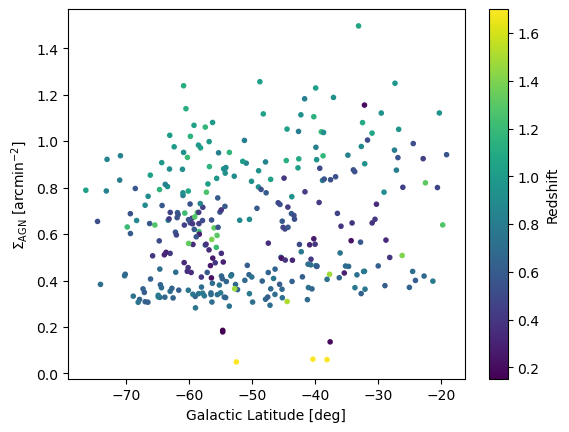

In [5]:
# Create plot
fig, ax = plt.subplots()
cb = ax.scatter(coords.galactic.b, sptcl_clusters['local_bkg'].to(u.arcmin ** -2), c=sptcl_clusters['REDSHIFT'],
                marker='.', cmap='viridis')
plt.colorbar(cb, label='Redshift')
ax.set(xlabel='Galactic Latitude [deg]', ylabel=r'$\Sigma_{\rm AGN}$ [arcmin$^{-2}$]')
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/plots/cluster_agn_surf_den/local_bkg_surf_den_frac_err_coords_z.pdf')

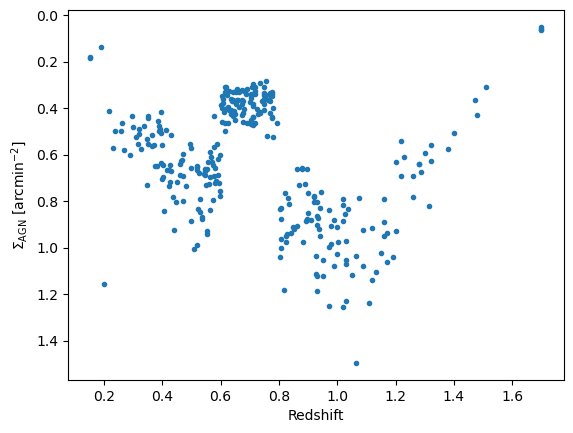

In [66]:
fig, ax = plt.subplots()
ax.scatter(sptcl_clusters['REDSHIFT'], sptcl_clusters['local_bkg'].to(u.arcmin**-2), marker='.')
ax.invert_yaxis()
ax.set(ylabel=r'$\Sigma_{\rm AGN}$ [arcmin$^{-2}$]', xlabel='Redshift')
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/plots/cluster_agn_surf_den/local_bkg_surf_den-redshift_inverted.pdf')

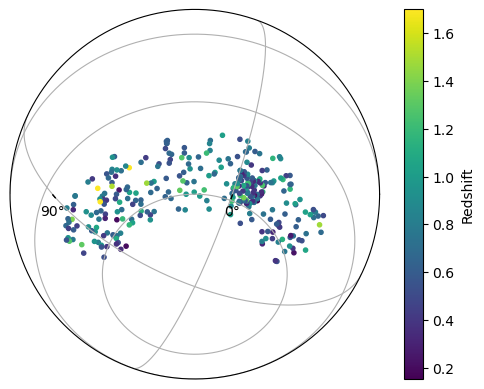

In [62]:
fig = plt.figure()
ax = plt.axes(projection='astro degrees globe', center='1h30m -60d')
ax.grid()
# cb = ax.scatter(coords.ra.deg, coords.dec.deg, marker='.', c=sptcl_clusters['local_bkg'].to_value(u.arcmin**-2), transform=ax.get_transform('world'))
cb = ax.scatter(coords.ra.deg, coords.dec.deg, marker='.', c=sptcl_clusters['REDSHIFT'], transform=ax.get_transform('world'))
# plt.colorbar(cb, label=r'$\Sigma_{\rm AGN}$ [arcmin$^{-2}$]')
plt.colorbar(cb, label='Redshift')

[Text(0.5, 0, 'Galactic Latitude [deg]'), Text(0, 0.5, '# AGN within Annulus')]

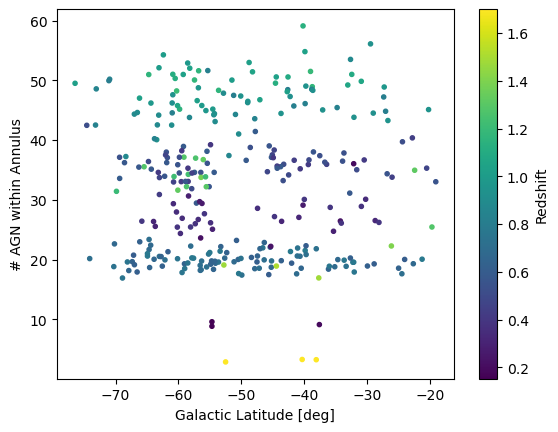

In [7]:
# Create plot
fig, ax = plt.subplots()
cb = ax.scatter(coords.galactic.b, sptcl_clusters['local_bkg'].to(u.arcmin ** -2) * sptcl_clusters['annulus_area'].to(u.arcmin**2), c=sptcl_clusters['REDSHIFT'],
                marker='.', cmap='viridis')
plt.colorbar(cb, label='Redshift')
ax.set(xlabel='Galactic Latitude [deg]', ylabel=r'# AGN within Annulus')

In [8]:
# Make a selection of clusters that are within a patch on the sky together
close_clusters_mask = coords[0].separation(coords) <= 10 * u.deg
close_clusters = sptcl_clusters[close_clusters_mask]

[Text(0, 0.5, 'Outer Annulus Radius [deg]'),
 Text(0.5, 0, 'Redshift'),
 Text(0.5, 1.0, 'All clusters within 10 deg of SPT-CLJ0000-4356')]

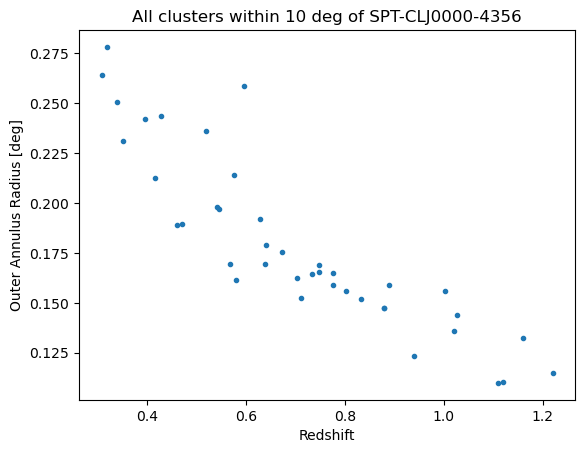

In [9]:
fig, ax = plt.subplots()
ax.scatter(close_clusters['REDSHIFT'], close_clusters['outer_radius'], marker='.')
ax.set(ylabel='Outer Annulus Radius [deg]', xlabel='Redshift', title=f'All clusters within 10 deg of {sptcl_clusters["SPT_ID"][0]}')

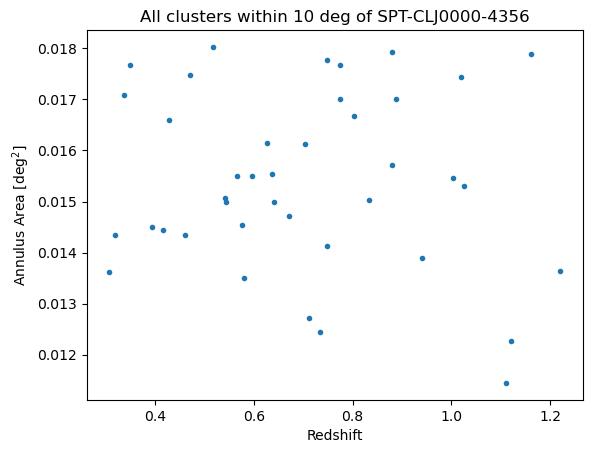

In [10]:
fig, ax = plt.subplots()
ax.scatter(close_clusters['REDSHIFT'], close_clusters['annulus_area'], marker='.')
ax.set(ylabel=r'Annulus Area [deg$^2$]', xlabel='Redshift', title=f'All clusters within 10 deg of {sptcl_clusters["SPT_ID"][0]}')
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/plots/cluster_agn_surf_den/local_bkg_close_clusters_areas.pdf')